In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,2,3,4"


In [4]:
from IPython.core.display import display, HTML

import numpy as np
means = np.load("data/means.npy").astype(np.float32)
covs = np.load("data/covs.npy").astype(np.float32)
xicovs = np.load("data/xicovs.npy").astype(np.float32)
signals = np.load("data/signals.npy").astype(np.float32)
A = np.load("data/A.npy").astype(np.float32)
dt = np.load("data/dt.npy")[0]
C = np.load("data/C.npy").astype(np.float32)
D = np.load("data/D.npy").astype(np.float32)

coeffs = [C, A, D , dt]



from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
from misc import *
import tensorflow as tf 

tfsignals = tf.convert_to_tensor(signals)
tfxicovs = tf.convert_to_tensor(xicovs)[:-1]


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [8]:
import tensorflow as tf


In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [22]:
batched_signals = tf.stack(tf.split(tfsignals, 10)) 
batched_xicovs  = tf.stack(tf.split(tfxicovs, 10))

inputs = (batched_xicovs, batched_signals)

In [23]:
from RNN_models import *

model = RecModel(coeffs, batch_size=len(batched_signals))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1))

model.fit(x=inputs, y=batched_signals, epochs=100, batch_size=model.batch_size)

/home/matias/.local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/home/matias/.local/lib/python3.9/site-packages/keras/engine/training.py:1841: UserWarning: Metric Metrica implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


Epoch 1/100
1/1 [==============================] - 1s 734ms/step - total_loss: 5.0614e-04
Epoch 2/100
1/1 [==============================] - 0s 217ms/step - total_loss: 5.0592e-04
Epoch 3/100
1/1 [==============================] - 0s 209ms/step - total_loss: 5.0571e-04
Epoch 4/100
1/1 [==============================] - 0s 222ms/step - total_loss: 5.0553e-04
Epoch 5/100
1/1 [==============================] - 0s 221ms/step - total_loss: 5.0540e-04
Epoch 6/100
1/1 [==============================] - 0s 213ms/step - total_loss: 5.0531e-04
Epoch 7/100
1/1 [==============================] - 0s 220ms/step - total_loss: 5.0525e-04
Epoch 8/100
1/1 [==============================] - 0s 221ms/step - total_loss: 5.0521e-04
Epoch 9/100
1/1 [==============================] - 0s 198ms/step - total_loss: 5.0517e-04
Epoch 10/100
1/1 [==============================] - 0s 234ms/step - total_loss: 5.0512e-04
Epoch 11/100
1/1 [==============================] - 0s 212ms/step - total_loss: 5.0505e-04
Epoch 12

1/1 [==============================] - 0s 208ms/step - total_loss: 5.0467e-04
Epoch 87/100
1/1 [==============================] - 0s 203ms/step - total_loss: 5.0467e-04
Epoch 88/100
1/1 [==============================] - 0s 228ms/step - total_loss: 5.0467e-04
Epoch 89/100
1/1 [==============================] - 0s 224ms/step - total_loss: 5.0467e-04
Epoch 90/100
1/1 [==============================] - 0s 214ms/step - total_loss: 5.0467e-04
Epoch 91/100
1/1 [==============================] - 0s 214ms/step - total_loss: 5.0467e-04
Epoch 92/100
1/1 [==============================] - 0s 230ms/step - total_loss: 5.0467e-04
Epoch 93/100
1/1 [==============================] - 0s 227ms/step - total_loss: 5.0467e-04
Epoch 94/100
1/1 [==============================] - 0s 232ms/step - total_loss: 5.0467e-04
Epoch 95/100
1/1 [==============================] - 0s 211ms/step - total_loss: 5.0467e-04
Epoch 96/100
1/1 [==============================] - 0s 212ms/step - total_loss: 5.0467e-04
Epoch 97/100

In [25]:
model.trainable_variables

[<tf.Variable 'rec_model/rnn/stacked_rnn_cells/minimal_rnn_cell/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.1792006 ,  1.0316011 ],
        [-0.19924954,  0.30155066]], dtype=float32)>,
 <tf.Variable 'rec_model/rnn/stacked_rnn_cells/minimal_rnn_cell/recurrent_kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.04651369,  0.03144619],
        [ 0.02611082, -0.00654482]], dtype=float32)>]

In [26]:
model.A

array([[ 0.  ,  1.  ],
       [-0.16,  0.  ]], dtype=float32)

In [27]:
series = ( tfxicovs[tf.newaxis,:10000,:,:], tfsignals[tf.newaxis,:10000,:] )

In [28]:
model.batch_size=1

In [29]:
predictions = model.rec_layer(series, initial_state=model.initial_state)

In [30]:
tfmeans = tf.convert_to_tensor(means.astype(np.float32))
Cxdt=tf.einsum('ij,kj->ki',model.C, tfmeans)*model.dt

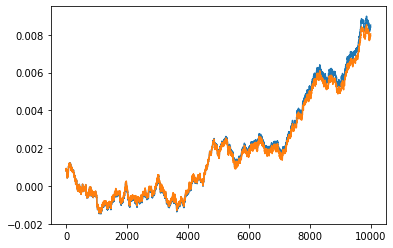

In [31]:
plt.plot(predictions[0][:,0])
plt.plot(Cxdt[:,0][:10000])